# Future projections of global hail hazard

In [1]:
%cd git/future_hail_global/

/home/561/tr2908/git/future_hail_global


In [2]:
import sys
sys.path.append('../xarray_parcel/')
sys.path.append('../aus400_hail/')
sys.path.append('../warming_levels/')
                
import dask
import xarray
import warnings
import numpy as np
import itertools
import pandas as pd
import seaborn as sns
from clef.code import *
import cartopy.crs as ccrs
from importlib import reload
import modules.fut_hail as fh
import matplotlib.pyplot as plt
import modules.warming_levels as wl
from dask.distributed import Client, Scheduler, LocalCluster

## Setup

In [3]:
_ = dask.config.set(**{'array.slicing.split_large_chunks': False})
client = Client()
print(client)

<Client: 'tcp://127.0.0.1:45005' processes=7 threads=28, memory=125.20 GiB>


## Settings

In [4]:
plt.show()                                        # Start the plotting engine.
plt.rcParams['font.size'] = 13                    # Font size for plots.
plt.rcParams['axes.formatter.useoffset'] = False  # Don't use offsets in plots.

## Model selection

Find models matching criteria. The following criteria are used to select models:

* Must contain variables:
     - `tas`, temperature at surface
     - `ta`, temperature by level
     - `uas`, u wind at surface
     - `ua`, u wind by level
     - `vas`, v wind at surface
     - `va`, v wind by level
     - `huss`, specific humidity at surface
     - `hus`, specific humidity by level
     - `ps`, surface pressure
* Must be available with a table ID of `3hr` or `6hrLev` (six hour minimum temporal resolution).
* Must include both `historical` and `ssp585` experiments.
* Must be available locally on NCI.

In [5]:
models = fh.select_all_models()

In [6]:
models

,model,ensemble,exp,institution_id,desc,CMIP6_dir
0,BCC-CSM2-MR,r1i1p1f1,historical,BCC,CMIP6.CMIP.BCC.BCC-CSM2-MR.historical.r1i1p1f1,/g/data/oi10/replicas
1,BCC-CSM2-MR,r1i1p1f1,ssp585,BCC,CMIP6.ScenarioMIP.BCC.BCC-CSM2-MR.ssp585.r1i1p1f1,/g/data/oi10/replicas
2,CMCC-CM2-SR5,r1i1p1f1,historical,CMCC,CMIP6.CMIP.CMCC.CMCC-CM2-SR5.historical.r1i1p1f1,/g/data/oi10/replicas
3,CMCC-CM2-SR5,r1i1p1f1,ssp585,CMCC,CMIP6.ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp585.r1i...,/g/data/oi10/replicas
4,CMCC-ESM2,r1i1p1f1,historical,CMCC,CMIP6.CMIP.CMCC.CMCC-ESM2.historical.r1i1p1f1,/g/data/oi10/replicas
5,CMCC-ESM2,r1i1p1f1,ssp585,CMCC,CMIP6.ScenarioMIP.CMCC.CMCC-ESM2.ssp585.r1i1p1f1,/g/data/oi10/replicas
6,CNRM-CM6-1,r1i1p1f2,historical,CNRM-CERFACS,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.historical....,/g/data/oi10/replicas
7,CNRM-CM6-1,r1i1p1f2,ssp585,CNRM-CERFACS,CMIP6.ScenarioMIP.CNRM-CERFACS.CNRM-CM6-1.ssp5...,/g/data/oi10/replicas
8,EC-Earth3,r1i1p1f1,historical,EC-Earth-Consortium,CMIP6.CMIP.EC-Earth-Consortium.EC-Earth3.histo...,/g/data/oi10/replicas
9,EC-Earth3,r1i1p1f1,ssp585,EC-Earth-Consortium,CMIP6.ScenarioMIP.EC-Earth-Consortium.EC-Earth...,/g/data/oi10/replicas


Now that models are selected, define runs over 20 year periods. We filter out models that
- do not cover the required times or
- are not available on pressure levels.

In [7]:
runs = fh.define_runs(models=models)

ACCESS-CM2 historical is not on pressure levels. Excluding ACCESS-CM2.
BCC-CSM2-MR historical requires 1980-1999, but data for va covers only 2012-2014. Excluding BCC-CSM2-MR.


In [8]:
runs[['model', 'ensemble', 'exp', 'start_year', 'end_year']]

,model,ensemble,exp,start_year,end_year
0,CMCC-CM2-SR5,r1i1p1f1,historical,1980,1999
1,CMCC-ESM2,r1i1p1f1,historical,1980,1999
2,CNRM-CM6-1,r1i1p1f2,historical,1980,1999
3,EC-Earth3,r1i1p1f1,historical,1980,1999
4,GISS-E2-1-G,r1i1p1f2,historical,1980,1999
5,MIROC6,r1i1p1f1,historical,1980,1999
6,MPI-ESM1-2-HR,r1i1p1f1,historical,1980,1999
7,MRI-ESM2-0,r1i1p1f1,historical,1980,1999
8,CMCC-CM2-SR5,r1i1p1f1,ssp585 (2C),2037,2056
9,CMCC-ESM2,r1i1p1f1,ssp585 (2C),2041,2060


If `orog` is available for surface elevation it is used. Some models are missing it, however, and if missing, orography from CNRM-CM6-1/historical/r1i1p1f2 is interpolated to the same grid and used. This code produce the backup orography per model with missing orography. It will not regenerate already-generated files. Note that the use of xemsf gridding routines seems to crash dask processes run using MPI on gadi, so this regridding has to be done "offline" here.

In [9]:
fh.make_backup_orography(runs)

In [10]:
runs.to_csv('results/runs_list.csv', index=False)

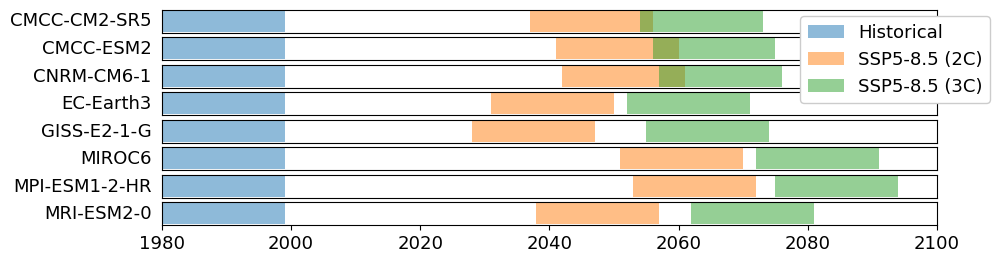

In [11]:
fh.plot_run_years(runs, file='results/run_years.pdf')

Note that grid information is missing from some files for MRI, CMCC, and MPI. The missing information is (as of 19.05.2023):

```
MRI: grid-spec gn, orog version gn/v20190603
CMCC: grid-spec gn, orog version gn/v20210126
MPI: grid-spec gn, orog version gn/v20190710
```

## Process CMIP6 data

Scripts are generated for each model/experiment, under
    
```
scripts/{model_name}/process_CMIP_{model_name}_{experiment}-1.sh
scripts/{model_name}/process_CMIP_{model_name}_{experiment}-2.sh
```

The first processes the first 10 years, the second the last 10 years.

Uncomment the following block to (re)create all scripts for generating convective indices for each run. 

In [12]:
# fh.make_run_scripts(runs=runs)

Post-processing into annual/seasonal statistics is done by writing the epochs to process to a CSV file:

In [13]:
# fh.make_postprocessing_scripts(runs=runs)

and then ensuring the job IDs match the number of epochs and running the script

```
post_process_CMIP.sh
```

## Read processed data

In [14]:
dat = fh.read_processed_data()

Regridding /g/data/up6/tr2908/future_hail_global/CMIP_conv_annual_stats/EC-Earth3_2C_2031-2050_native_grid.nc.


**CHECK that each model contains the correct epoch and number of timesteps in the annual/seasonal stats**

## Global hail climatology for historical period

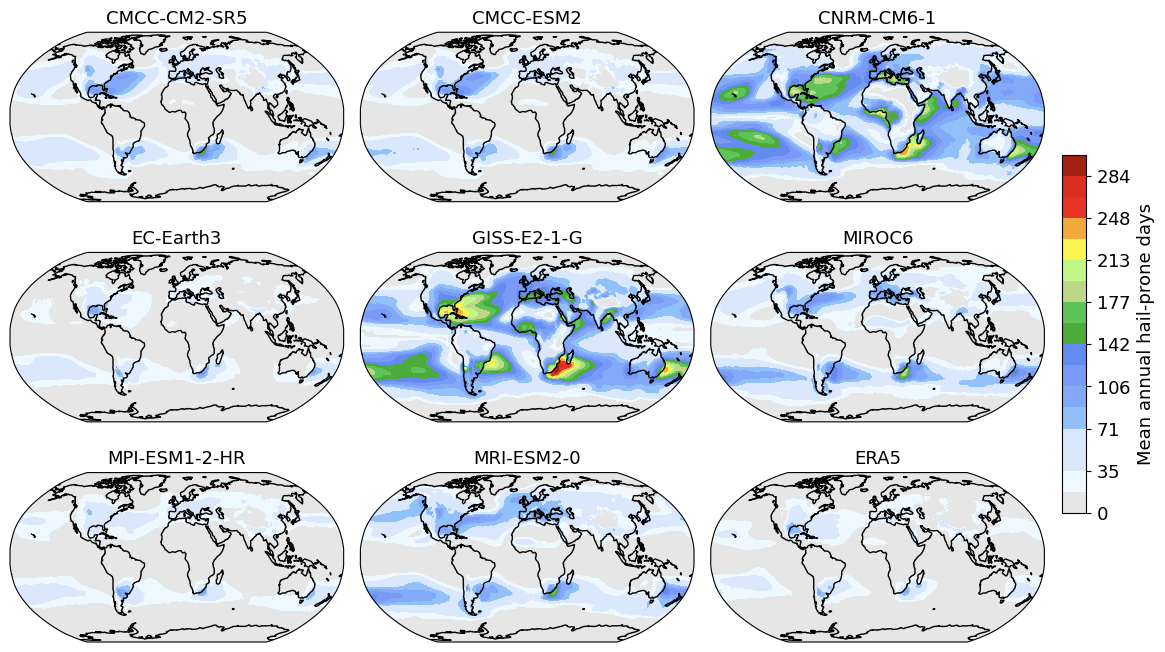

In [71]:
_ = fh.plot_map([dat.annual_hail_proxy.mean('year_num').sel(model=m, epoch='historical') for m in dat.model] + [era5],
                title=[f'{m}' for m in dat.model.values] + ['ERA5'], figsize=(12,6.5), disp_proj=ccrs.Robinson(),
                ncols=3, nrows=3, share_scale=True, share_axes=True, grid=False, contour=True,
                scale_label='Mean annual hail-prone days', file='results/historical_by_model.pdf')

## Comparison with ERA5 climatology

In [64]:
reload(fh)
cmip6 = dat.annual_hail_proxy.mean(['model', 'year_num']).sel(epoch='historical').load()
era5 = fh.era5_climatology().annual_mean_hail_proxy.load()

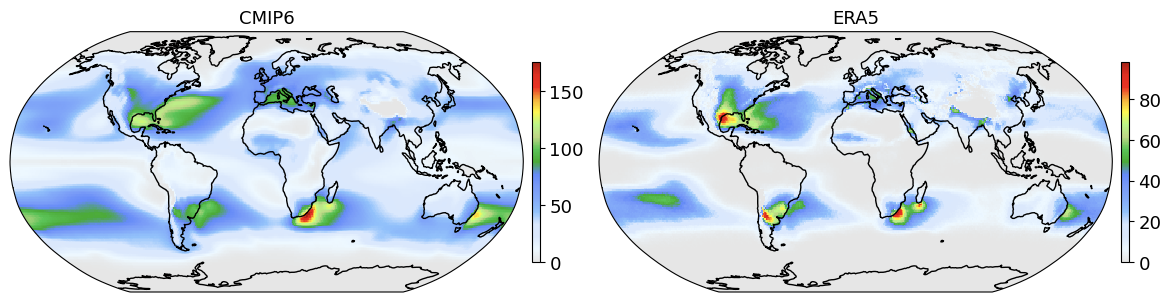

In [67]:
_ = fh.plot_map([cmip6, era5], title=['CMIP6', 'ERA5'], cbar_label='',
                figsize=(11.5,5), ncols=2, nrows=1, share_scale=False, share_axes=True, grid=False,
                disp_proj=ccrs.Robinson(), file='results/CMIP6_ERA5_comparison_historical.pdf')

In [56]:
reload(fh)

<module 'modules.fut_hail' from '/home/561/tr2908/git/future_hail_global/modules/fut_hail.py'>

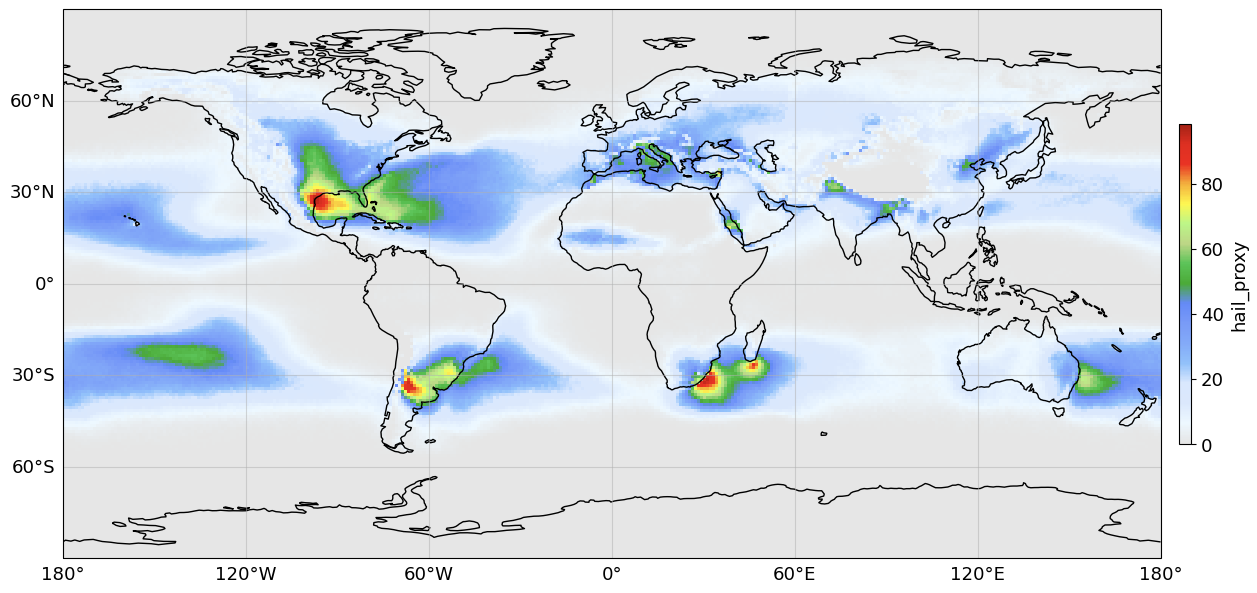

<GeoAxesSubplot:xlabel='longitude', ylabel='latitude'>

<xarray.DataArray 'hail_proxy' (latitude: 180, longitude: 360)>
dask.array<mean_agg-aggregate, shape=(180, 360), dtype=float64, chunksize=(180, 360), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5

## Differences between epochs

In [ ]:
import scipy as sp

def calc_diffs(dat, variables='annual_hail_proxy', epochs=['2C', '3C']):

    # Find the differences in means between historical and each epoch. 
    means = dat[[variables]].mean(['year_num'])

    all_diffs = []
    for e in ['2C', '3C']:
        diffs = means.sel(epoch=e) - means.sel(epoch='historical')
        all_diffs.append(diffs.expand_dims({'epoch': [e]}))
    all_diffs = xarray.merge(all_diffs)

statres, pval = sp.stats.ttest_rel(a=dat.sel(epoch=fut_epoch, model=model, season='DJF')[variable].values, 
                                   b=dat.sel(epoch=hist_epoch, model=model, season='DJF')[variable].values)
    
    return all_diffs

In [ ]:
diffs = calc_diffs(dat=dat, variables='annual_hail_proxy')

In [ ]:
diffs = list(itertools.chain(*zip([all_diffs.annual_hail_proxy.sel(model=m, epoch='2C') for m in all_diffs.model], 
                                  [all_diffs.annual_hail_proxy.sel(model=m, epoch='3C') for m in all_diffs.model])))

In [ ]:
_ = fh.plot_map(diffs, col_labels=['2C', '3C'], row_labels=all_diffs.model.values, 
                row_label_rotation=0, row_label_scale=1.285, row_label_offset=-0.06, row_label_adjust=0.15,
                figsize=(12,17), disp_proj=ccrs.Robinson(), cmap='RdBu_r', divergent=True,
                ncols=2, nrows=8, share_scale=True, share_axes=True, grid=False, contour=True,
                scale_label='Difference in mean annual hail-prone days', file='results/hail_differences_by_model.pdf')

In [ ]:
model = 'CMCC-ESM2'
hist_epoch = 'historical'
fut_epoch = '2C'

variable = 'seasonal_hail_proxy'
statres, pval = sp.stats.ttest_rel(a=dat.sel(epoch=fut_epoch, model=model, season='DJF')[variable].values, 
                                   b=dat.sel(epoch=hist_epoch, model=model, season='DJF')[variable].values)

In [ ]:
res_dims = list(dat.sel(epoch=fut_epoch, model=model)[variable].dims)[1:]
{x: dat[x].values for x in res_dims}

In [ ]:
reload(fh)

In [ ]:
d = fh.ttest(dat=dat, fut_epoch='2C', variable='seasonal_hail_proxy')

In [ ]:
dat

In [ ]:
fut_epoch='2C'

res = []
for variable in ['annual_hail_proxy']:
    print(variable)
    tt = fh.ttest(dat=dat, fut_epoch=fut_epoch, variable=variable)
    diffs = dat[variable].sel(epoch=fut_epoch) - dat[variable].sel(epoch='historical')

    r = xarray.Dataset({f'{variable}_mean_diff': diffs.mean('year_num'),
                        f'{variable}_sig_diff': tt.sig})
    r[f'{variable}_mean_diff'].attrs = dat[variable].attrs
    res.append(r)
    
res = xarray.merge(res)

In [ ]:
diffs = res
variable = 'annual_hail_proxy_mean_diff'
diffs[variable]

In [ ]:
diffs = res
variable = 'annual_hail_proxy_mean_diff'

In [ ]:
reload(fh)

sign_aggreement = (np.sign(diffs[variable]).sum('model'))
significant_change = tt.sig.sum('model')
s = np.logical_and(significant_change == dat.model.size,
                   np.abs(sign_aggreement) == dat.model.size)
                  
m = diffs[variable].mean('model')
m.attrs['long_name'] = 'Mean change in annual hail-prone days'
    
_ = fh.plot_map(dat=m, grid=False, divergent=True,
                scale_label='Mean change in annual hail-prone days',
                stippling=s, cmap='RdBu_r', figsize=(12,6), disp_proj=ccrs.Robinson())

Using [Metagrid](https://aims2.llnl.gov/search) to search for CMIP6 data with:

Variables: ua, uas, va, vas, ta, tas, hus, huss, ps
Table ID: 6hrLev, 3hr
Experiments: ssp585, historical
Variant: r1i1p1f1
Resolutions: 50, 100, 250 km

And then selecting models one by one and looking for those with >18 results (9 variables, two experiments):

Not available on NCI - requested

* BCC-CSM2-MR
    - `CMIP6.CMIP.BCC.BCC-CSM2-MR.historical.r1i1p1f1`
    - `CMIP6.ScenarioMIP.BCC.BCC-CSM2-MR.ssp585.r1i1p1f1`

* CMCC-CM2-SR5
    - `CMIP6.CMIP.CMCC.CMCC-CM2-SR5.historical.r1i1p1f1`
    - `CMIP6.ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp585.r1i1p1f1`
    
* CNRM-CM6-1
    - `CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.r1i1p1f2`
    - `CMIP6.ScenarioMIP.CNRM-CERFACS.CNRM-CM6-1.ssp585.r1i1p1f2`
    
* GISS-E2-1-G (250 km)
    - `CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1i1p1f2`
    - `CMIP6.ScenarioMIP.NASA-GISS.GISS-E2-1-G.ssp585.r1i1p1f2`
    
* MIROC6 (250 km)
    - `CMIP6.CMIP.MIROC.MIROC6.historical.r1i1p1f1`
    - `CMIP6.ScenarioMIP.MIROC.MIROC6.ssp585.r1i1p1f1`
    
* NESM3
    - `CMIP6.CMIP.NUIST.NESM3.historical.r1i1p1f1`
    - `CMIP6.ScenarioMIP.NUIST.NESM3.ssp585.r1i1p1f1`


